This is an extension of [this](https://www.kaggle.com/kageyama/fork-of-fastai-blindness-detection-resnet34) notebook, which extends upon [this](https://www.kaggle.com/kageyama/fastai-blindness-detection-resnet34) notebook.

In this experiment, I try ordinal variables using [this](https://arxiv.org/abs/0704.1028) technique. Basically, I transform the targets to look like multilabel classification, then apply this method for making predictions:

> "...our methods scans output nodes in the order O1, O2,....,OK. It stop when the output of a node is smaller than the predefined threshold T (e.g. 0.5) or no nodes left. The index k of the last node Ok whose output is bigger than T is the predicted category of the data point."

So basically, I'll apply sigmoid to the model's outputs, then threshold at 0.5 and find the position one before the first zero.

In [29]:
%matplotlib inline  
# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# data visualisation and manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

from sklearn.metrics import confusion_matrix
from fastai import *
from fastai.vision import *
from fastai.callbacks import Callback

# specifically for manipulating zipped images and getting numpy arrays of pixel values of images.
import cv2                  
import numpy as np  
from tqdm import tqdm
import os                   
from random import shuffle  
from zipfile import ZipFile
from PIL import Image
from sklearn.utils import shuffle

print(os.listdir("../input"))

['resnet34', 'aptos2019-blindness-detection', 'diabetic-retinopathy-detection']


In [30]:
# copy pretrained weights for resnet34 to the folder fastai will search by default
Path('/tmp/.cache/torch/checkpoints/').mkdir(exist_ok=True, parents=True)
!cp '../input/resnet34/resnet34.pth' '/tmp/.cache/torch/checkpoints/resnet34-333f7ec4.pth'

In [31]:
df_train = pd.read_csv('../input/aptos2019-blindness-detection/train.csv')
df_test = pd.read_csv('../input/aptos2019-blindness-detection/test.csv')

x_train = df_train['id_code']
y_train = df_train['diagnosis']

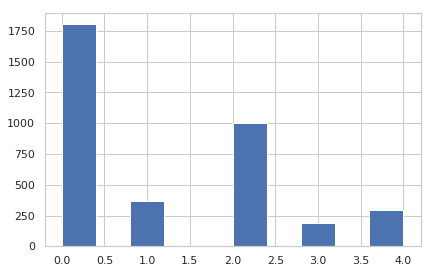

In [32]:
df_train.diagnosis.hist()

In [33]:
import torch
import torch.utils.data
import torchvision

In [34]:
print(os.listdir("../input/aptos2019-blindness-detection/")) 

['sample_submission.csv', 'train_images', 'train.csv', 'test.csv', 'test_images']


In [35]:
def get_label(diagnosis):
    return ','.join([str(i) for i in range(diagnosis + 1)])

In [36]:
df_train['label'] = df_train.diagnosis.apply(get_label)

In [37]:
df_train.head(10)

,id_code,diagnosis,label
0,000c1434d8d7,2,"0,1,2"
1,001639a390f0,4,"0,1,2,3,4"
2,0024cdab0c1e,1,"0,1"
3,002c21358ce6,0,0
4,005b95c28852,0,0
5,0083ee8054ee,4,"0,1,2,3,4"
6,0097f532ac9f,0,0
7,00a8624548a9,2,"0,1,2"
8,00b74780d31d,2,"0,1,2"
9,00cb6555d108,1,"0,1"


In [38]:
# create image data bunch
data = ImageDataBunch.from_df('./', 
                              df=df_train, 
                              valid_pct=0.2,
                              folder="../input/aptos2019-blindness-detection/train_images",
                              suffix=".png",
                              ds_tfms=get_transforms(flip_vert=True, max_warp=0),
                              size=224,
                              bs=64, 
                              num_workers=0,
                             label_col='label', label_delim=',').normalize(imagenet_stats)

In [39]:
# check classes
print(f'Classes: \n {data.classes}')

Classes: 
 ['0', '1', '2', '3', '4']


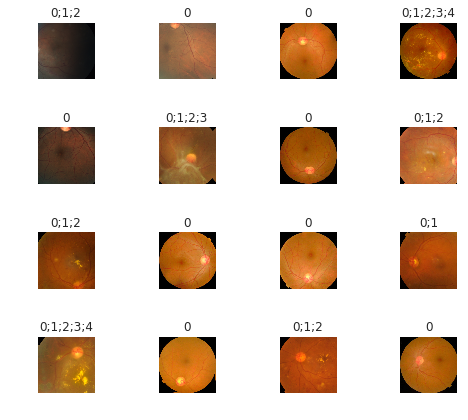

In [41]:
# show some sample images
data.show_batch(rows=4, figsize=(7,6))